In [3]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# LOAD DATA (CSV tidy)

# Expected columns: Metabolite, Treatment, Replicate, Value
df = pd.read_csv("metabolomics_example_A-I_tidy.csv")

required_cols = {"Metabolite", "Treatment", "Replicate", "Value"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"CSV must contain columns: {required_cols}")

df["Treatment"] = df["Treatment"].astype(str)
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Value"])

# CONFIGURATION
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

treatments_vs_NT = [t for t in labels if t != "NT"]

# pvalue
def stars(p):
    if p is None or np.isnan(p):
        return ""
    if p < 0.0001:
        return "****"
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return ""

# T-TEST vs Control (e.g. A)

rows = []
for metabolite, sub in df.groupby("Metabolite"):

    nt_vals = sub[sub["Treatment"] == "A"]["Value"].values

    if len(nt_vals) < 2:
        continue

    row = {
        "Metabolite": metabolite,
        "A": np.mean(nt_vals)
    }

    for treatment in treatments_vs_NT:
        vals = sub[sub["Treatment"] == treatment]["Value"].values

        if len(vals) < 2:
            p_val = np.nan
        else:
            _, p_val = ttest_ind(vals, nt_vals, equal_var=True, nan_policy="omit")

        row[f"sig_{treatment}_vs_A"] = stars(p_val)

    rows.append(row)

out_df = pd.DataFrame(rows)
out_df.to_csv("metaboliti_NT_sigonly.csv", index=False)
print("File salvato come: metaboliti_NT_sigonly.csv")
out_df.head()


File salvato come: metaboliti_NT_sigonly.csv


,Metabolite,A,sig_A_vs_A,sig_B_vs_A,sig_C_vs_A,sig_D_vs_A,sig_E_vs_A,sig_F_vs_A,sig_G_vs_A,sig_H_vs_A,sig_I_vs_A
0,Alpha_ketoglutaric_acid,0.000012,,**,,,,,,**,
1,Alpha_tocopherol,0.000012,,*,,,,**,*,,*
2,Beta_sitosterol,0.000009,,,*,,**,,,,
3,Chlorophyll_a,0.003781,,,,,,,,,
4,Chlorophyll_b,0.000001,,,*,,,,,,


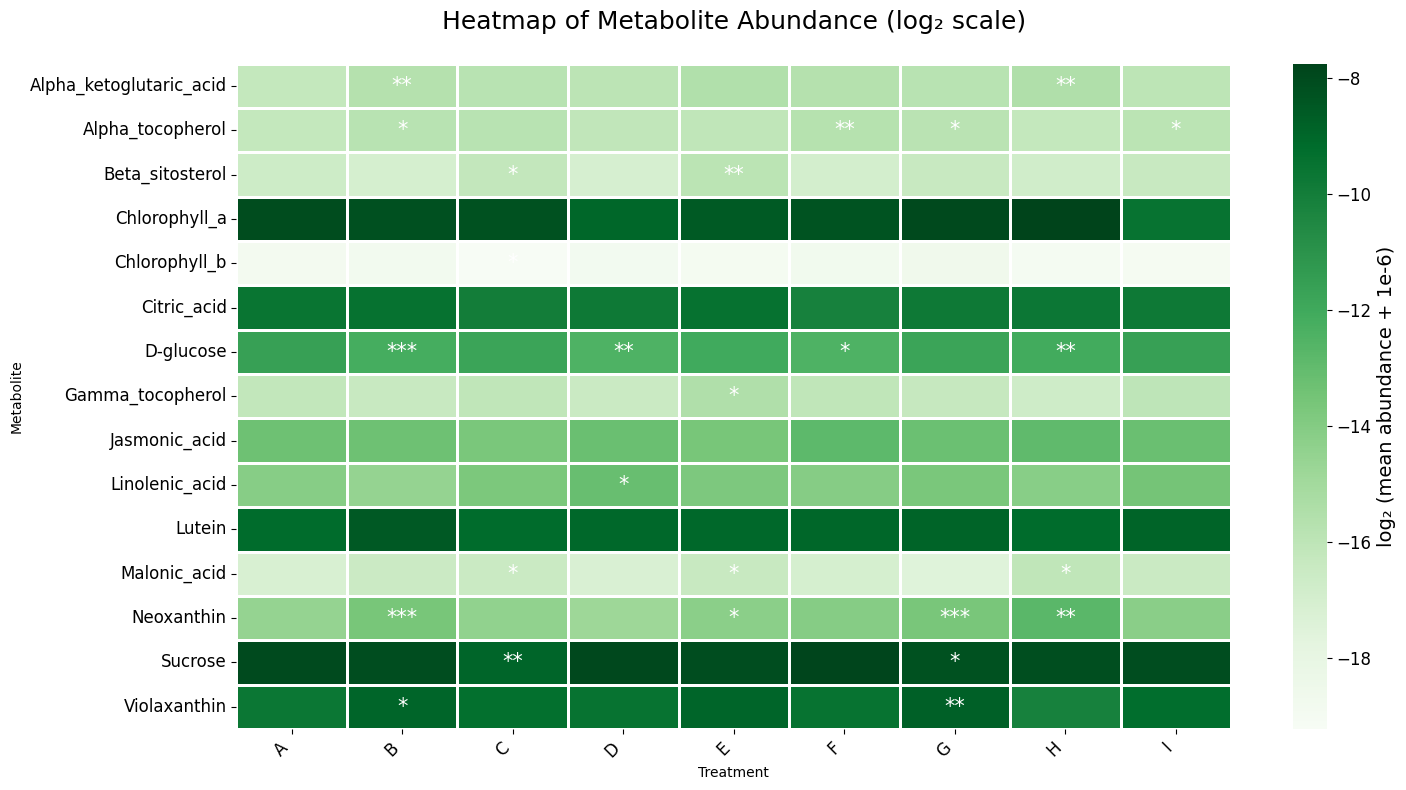

In [4]:
## HEATMAP log2 + *pvalue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD DATA (CSV tidy)

df_raw = pd.read_csv("metabolomics_example_A-I_tidy.csv")

required_cols = {"Metabolite", "Treatment", "Replicate", "Value"}
if not required_cols.issubset(df_raw.columns):
    raise ValueError(f"CSV must contain columns: {required_cols}")

df_raw["Treatment"] = df_raw["Treatment"].astype(str)
df_raw["Value"] = pd.to_numeric(df_raw["Value"], errors="coerce")
df_raw = df_raw.dropna(subset=["Value"])

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

# MEAN
df_means = (
    df_raw.groupby(["Metabolite", "Treatment"])["Value"]
          .mean()
          .reset_index()
)

df_means["Treatment"] = pd.Categorical(df_means["Treatment"], categories=labels, ordered=True)
df_means = df_means.sort_values(["Metabolite", "Treatment"])

df = df_means.pivot(index="Metabolite", columns="Treatment", values="Value")

df = df.reindex(columns=labels)

# LOG2 TRANSFORMATION
df[df < 0] = np.nan
df_log2 = np.log2(df + 1e-6)

# IMPORT ASTERISKS FROM CSV
sig_df = pd.read_csv("metaboliti_NT_sigonly.csv").set_index("Metabolite")

stars_matrix = pd.DataFrame("", index=df_log2.index, columns=df_log2.columns)

for metab in df_log2.index:
    for tr in df_log2.columns:
        if tr == "A":
            stars_matrix.loc[metab, tr] = ""
            continue

        col = f"sig_{tr}_vs_A"
        if metab in sig_df.index and col in sig_df.columns:
            val = sig_df.loc[metab, col]
            stars_matrix.loc[metab, tr] = val if isinstance(val, str) else ""
        else:
            stars_matrix.loc[metab, tr] = ""

# HEATMAP + stars
plt.figure(figsize=(15, 8))

ax = sns.heatmap(
    df_log2,
    cmap="Greens",   #green color
    linewidths=1,
    linecolor="white",
    cbar=True,
    cbar_kws={"label": "log₂ (mean abundance + 1e-6)"},
)

# full-height colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel("log₂ (mean abundance + 1e-6)", fontsize=14)

pos = ax.get_position()
cbar.ax.set_position([pos.x1 + 0.02, pos.y0, 0.02, pos.height])

plt.title("Heatmap of Metabolite Abundance (log₂ scale)", fontsize=18, pad=25)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# overlay asterisks
for i, metab in enumerate(df_log2.index):
    for j, tr in enumerate(df_log2.columns):
        text = stars_matrix.loc[metab, tr]
        if text and str(text).lower() != "nan":
            ax.text(j + 0.5, i + 0.5, text,
                    ha="center", va="center",
                    fontsize=15, color="white")

plt.tight_layout()
plt.show()


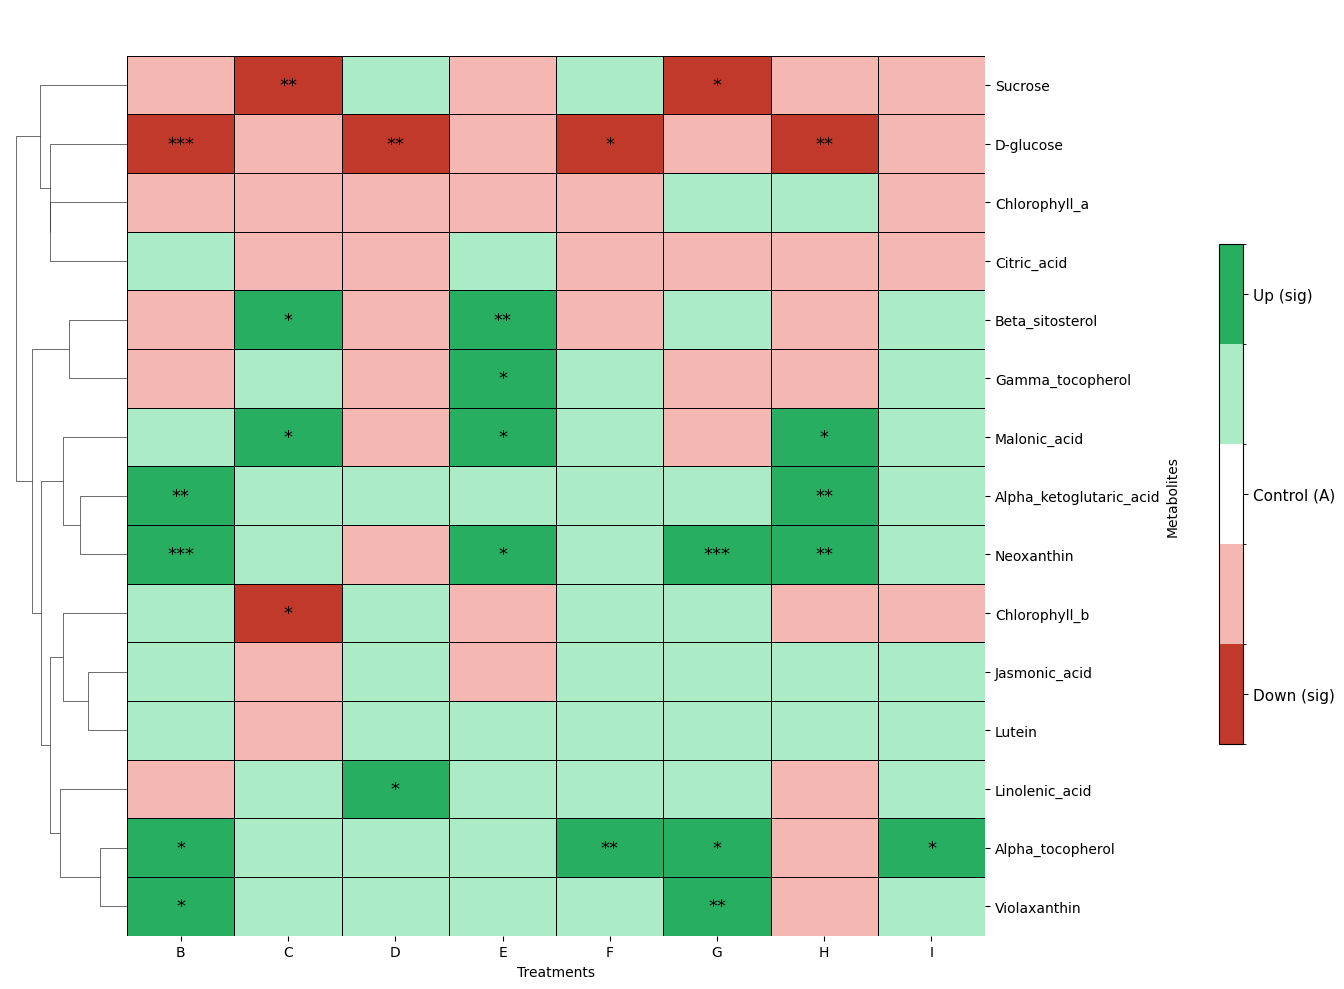

In [9]:
## HEATMAP BICOLOR + *pvalue

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl

# LOAD DATA (CSV tidy)

df_raw = pd.read_csv("metabolomics_example_A-I_tidy.csv")

required_cols = {"Metabolite", "Treatment", "Replicate", "Value"}
if not required_cols.issubset(df_raw.columns):
    raise ValueError(f"CSV must contain columns: {required_cols}")

df_raw["Treatment"] = df_raw["Treatment"].astype(str)
df_raw["Value"] = pd.to_numeric(df_raw["Value"], errors="coerce")
df_raw = df_raw.dropna(subset=["Value"])

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
control = "A" # Define control here

# MEAN MATRIX + LOG2
df_means = (
    df_raw.groupby(["Metabolite", "Treatment"])["Value"]
          .mean()
          .reset_index()
)

df_means["Treatment"] = pd.Categorical(df_means["Treatment"], categories=labels, ordered=True)
df_means = df_means.sort_values(["Metabolite", "Treatment"])

df_m = df_means.pivot(index="Metabolite", columns="Treatment", values="Value").reindex(columns=labels)

# log2 transform
df_m[df_m < 0] = np.nan
df_m = np.log2(df_m + 1e-6)

# LOAD STARS (sig file)
sig_df = pd.read_csv("metaboliti_NT_sigonly.csv").set_index("Metabolite")

def is_significant_marker(x) -> bool:
    """True if x contains at least one star."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return False
    s = str(x).strip()
    return "*" in s and s != ""

stars_m = pd.DataFrame("", index=df_m.index, columns=df_m.columns)

for metab in stars_m.index:
    for tr in stars_m.columns:
        if tr == control:
            stars_m.loc[metab, tr] = ""
            continue
        col = f"sig_{tr}_vs_{control}"
        if metab in sig_df.index and col in sig_df.columns:
            val = sig_df.loc[metab, col]
            stars_m.loc[metab, tr] = str(val).strip() if isinstance(val, str) else ""
        else:
            stars_m.loc[metab, tr] = ""

# BUILD CATEGORY MATRIX C
common_idx = df_m.index.intersection(stars_m.index) # Defined here
treat_cols = df_m.columns  # Defined here

df_m = df_m.loc[common_idx, treat_cols]
stars_m = stars_m.loc[common_idx, treat_cols]

C = pd.DataFrame(0, index=common_idx, columns=treat_cols, dtype=int)

tol = 0.0

for tr in treat_cols:
    if tr == control:
        C[tr] = 0
        continue

    sig = stars_m[tr].apply(is_significant_marker)
    diff = df_m[tr] - df_m[control] # Use 'control' variable

    up = diff > tol
    down = diff < -tol

    C.loc[up & ~sig, tr] =  1
    C.loc[up &  sig, tr] =  2
    C.loc[down & ~sig, tr] = -1
    C.loc[down &  sig, tr] = -2

cmap = ListedColormap(
    [
        "#c0392b",  #darkred  (sig down)
        "#f5b7b1",  #lightred (non-sig down)
        "#ffffff",  #white       (0)
        "#abebc6",  #lightgreen (non-sig up)
        "#27ae60",  #darkgreen  (sig up)
    ]
)

bounds = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

# REMOVE CONTROL COLUMN (A) FROM PLOT ONLY

C_plot = C.drop(columns=[control])
stars_plot = stars_m.drop(columns=[control])

# CLUSTERMAP
g = sns.clustermap(
    C_plot,
    row_cluster=True,
    col_cluster=False,
    method="average",
    metric="euclidean",
    cmap=cmap,
    norm=norm,
    linewidths=0.0,
    figsize=(12, 10),
    dendrogram_ratio=(0.12, 0.05),
    cbar_pos=None,
)

mesh = g.ax_heatmap.collections[0]
mesh.set_edgecolor("black")
mesh.set_linewidth(0.7)

g.ax_heatmap.set_xlabel("Treatments")
g.ax_heatmap.set_ylabel("Metabolites")


# *pvalue
row_order = g.data2d.index
col_order = g.data2d.columns

for i, metab in enumerate(row_order):
    for j, tr in enumerate(col_order):
        star = stars_m.loc[metab, tr]
        if is_significant_marker(star):
            g.ax_heatmap.text(
                j + 0.5, i + 0.5, str(star).strip(),
                ha="center", va="center",
                fontsize=13, color="black"
            )

colors = [
    "#c0392b",
    "#f5b7b1",
    "#ffffff",
    "#abebc6",
    "#27ae60",
]

cmap_cb = mpl.colors.ListedColormap(colors)
bounds = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
norm_cb = mpl.colors.BoundaryNorm(bounds, cmap_cb.N)

cax = g.fig.add_axes([1.02, 0.25, 0.02, 0.5])

cb = mpl.colorbar.ColorbarBase(
    cax,
    cmap=cmap_cb,
    norm=norm_cb,
    boundaries=bounds,
    orientation="vertical"
)

# labels
cb.set_ticks([2, 0, -2])
cb.set_ticklabels([
    "Up (sig)",
    f"Control ({control})",
    "Down (sig)"
])

cb.ax.tick_params(labelsize=11)

plt.show()

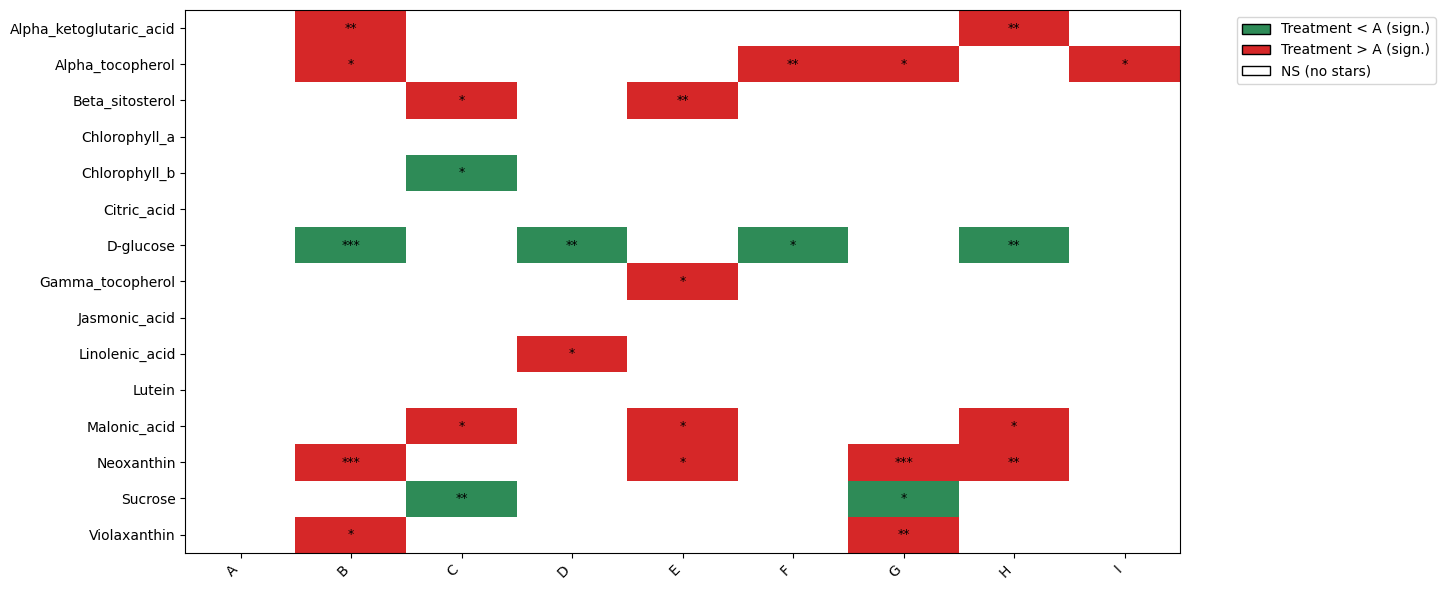

In [10]:
## HEATMAP BICOLOR - just *pvalue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Load CSVs

df_raw = pd.read_csv("metabolomics_example_A-I_tidy.csv")
df_sig = pd.read_csv("metaboliti_NT_sigonly.csv")

required_cols = {"Metabolite", "Treatment", "Replicate", "Value"}
if not required_cols.issubset(df_raw.columns):
    raise ValueError(f"CSV tidy must contain columns: {required_cols}")

df_raw["Treatment"] = df_raw["Treatment"].astype(str)
df_raw["Value"] = pd.to_numeric(df_raw["Value"], errors="coerce")
df_raw = df_raw.dropna(subset=["Value"])

df_sig = df_sig.set_index("Metabolite")

# Configuration (A is control)

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
control = "A"

# If you want to hide control column from the plot, set this to True
drop_control_from_plot = False

display_treatments = labels.copy()
if drop_control_from_plot:
    display_treatments = [t for t in labels if t != control]

df_means = (
    df_raw.groupby(["Metabolite", "Treatment"])["Value"]
          .mean()
          .reset_index()
)

df_means["Treatment"] = pd.Categorical(df_means["Treatment"], categories=labels, ordered=True)
df_means = df_means.sort_values(["Metabolite", "Treatment"])

mean_wide = df_means.pivot(index="Metabolite", columns="Treatment", values="Value").reindex(columns=labels)

metabolites = mean_wide.index.tolist()

mean_matrix = mean_wide.values.astype(float)

n_met, n_tr = mean_matrix.shape
sig_matrix = np.empty((n_met, n_tr), dtype=object)
sig_matrix[:] = ""

for j, tr in enumerate(labels):
    if tr == control:
        sig_matrix[:, j] = ""
        continue

    col = f"sig_{tr}_vs_{control}"
    if col not in df_sig.columns:
        print(f"[WARN] Column not found in sig file: {col}")
        continue

    vals = df_sig.reindex(metabolites)[col].fillna("").astype(str).values
    sig_matrix[:, j] = vals

# Compute color matrix vs control (ONLY if significant)
control_idx = labels.index(control)
control_vals = mean_matrix[:, control_idx]

color_matrix = np.zeros_like(mean_matrix, dtype=int)

for i in range(n_met):
    for j in range(n_tr):
        if j == control_idx:
            color_matrix[i, j] = 0
            continue

        stars = str(sig_matrix[i, j]).strip()
        if stars == "" or stars.lower() == "nan":
            color_matrix[i, j] = 0  # not significant -> white
            continue

        diff = mean_matrix[i, j] - control_vals[i]

        if diff > 0:
            color_matrix[i, j] = -1   # red: treatment > control
        elif diff < 0:
            color_matrix[i, j] =  1   # green: treatment < control
        else:
            color_matrix[i, j] = 0

# If you want to drop control column from plot only
if drop_control_from_plot:
    keep_cols = [labels.index(t) for t in display_treatments]
    color_matrix_plot = color_matrix[:, keep_cols]
    sig_matrix_plot = sig_matrix[:, keep_cols]
else:
    color_matrix_plot = color_matrix
    sig_matrix_plot = sig_matrix

# Colormap red-white-green
cmap = ListedColormap([
    "#D62728",  # -1 red (treatment > control)
    "#FFFFFF",  #  0 white (NS)
    "#2E8B57"   # +1 green (treatment < control)
])

bounds = [-1.5, -0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

# Plot heatmap (categorical)
fig_h = max(6, n_met * 0.35)
fig, ax = plt.subplots(figsize=(12, fig_h))

im = ax.imshow(color_matrix_plot, cmap=cmap, norm=norm, aspect="auto")

ax.set_xticks(np.arange(len(display_treatments)))
ax.set_xticklabels(display_treatments, rotation=45, ha="right")

ax.set_yticks(np.arange(n_met))
ax.set_yticklabels(metabolites)

# Add stars on significant cells
for i in range(n_met):
    for j in range(len(display_treatments)):
        stars = str(sig_matrix_plot[i, j]).strip()
        if stars != "" and stars.lower() != "nan":
            ax.text(j, i, stars, ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()

legend_elements = [
    Patch(facecolor="#2E8B57", edgecolor="k", label=f"Treatment < {control} (sign.)"),
    Patch(facecolor="#D62728", edgecolor="k", label=f"Treatment > {control} (sign.)"),
    Patch(facecolor="#FFFFFF", edgecolor="k", label="NS (no stars)"),
]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()
